This notebook is inpired by [Detailed EDA by Erik Bruin](https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda/report#loading-and-exploring-data)


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
# Read training and testing data sets
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
all_data = pd.concat([train, test], axis='index')

In [3]:
# Shape of data
print("Training Data Shape: ",train.shape)
print("Testing Data Shape: ", test.shape)

Training Data Shape:  (1460, 81)
Testing Data Shape:  (1459, 80)


In [4]:
# data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Split data into Input variables and Target Variable
# remove the Id column from training data (not useful)
y_train = train['SalePrice']
X_train = train.drop(['SalePrice', 'Id'], axis='columns')

# remove Id column from testing data but keep it for submission
X_test = test.drop(['Id'], axis='columns')
X_test_ids = test['Id']

In [6]:
# Explore some stats about our target variable SalePrice
y_train.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

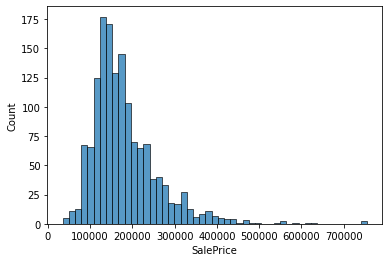

In [7]:
# Explore the distribution of the target variable
sns.histplot(data= y_train)

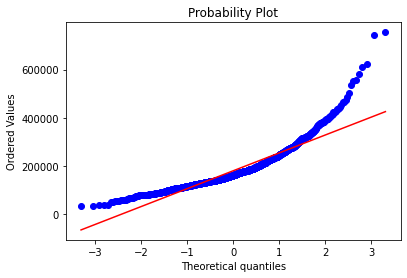

In [8]:
# it is apparently not normally distributed, let's see how far it is from normal distribution
# using Q–Q (quantile-quantile) plot
fig = plt.figure()
res = stats.probplot(x = y_train, plot= plt, dist='norm')
plt.show()

In [9]:
# divide columns into categorical and numeric
cat_cols = X_train.select_dtypes('object').columns.to_list()
num_cols = X_train.select_dtypes('number').columns.to_list()

In [10]:
# Check Numeric Variables First
print(f'There are {len(num_cols)} numeric variables') # excluding the Id column

# Let's see how they correlate with the target variable
num_corr_target = X_train[num_cols].corrwith(y_train, axis='index').sort_values(ascending=False)

# Let's see how many highly correlate (has correlation coefficient >= |0.5|)
print(f'Numeric features with high correlation (>= |0.5|) to target variable:')
high_num_corr_target = num_corr_target[num_corr_target >= abs(0.5)]
print(high_num_corr_target)

high_num_corr_target_matrix = train[high_num_corr_target.index.to_list() + ['SalePrice']].corr()
high_num_corr_target_matrix

There are 36 numeric variables
Numeric features with high correlation (>= |0.5|) to target variable:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
dtype: float64


,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,SalePrice
OverallQual,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.427452,0.572323,0.550684,0.790982
GrLivArea,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.825489,0.199010,0.287389,0.708624
GarageCars,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.362289,0.537850,0.420622,0.640409
GarageArea,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.337822,0.478954,0.371600,0.623431
TotalBsmtSF,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.285573,0.391452,0.291066,0.613581
1stFlrSF,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.409516,0.281986,0.240379,0.605852
FullBath,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.554784,0.468271,0.439046,0.560664
TotRmsAbvGrd,0.427452,0.825489,0.362289,0.337822,0.285573,0.409516,0.554784,1.000000,0.095589,0.191740,0.533723
YearBuilt,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,0.095589,1.000000,0.592855,0.522897
YearRemodAdd,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.191740,0.592855,1.000000,0.507101


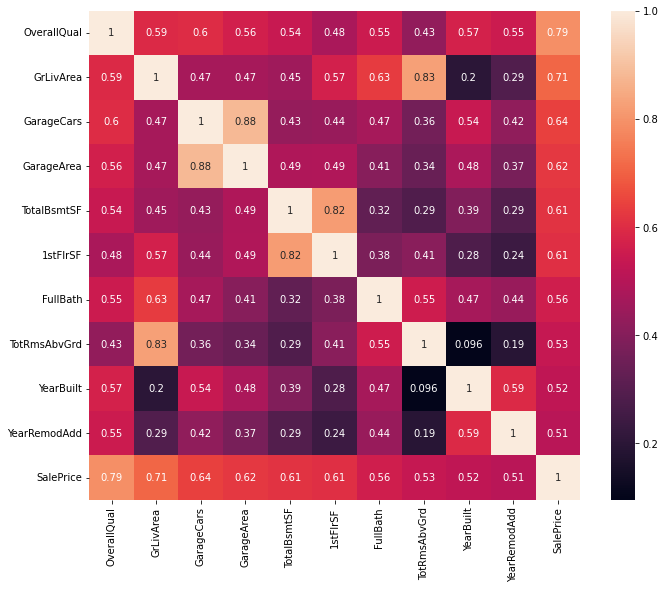

In [11]:
# Visualize the correlation matrix using heatmap
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(high_num_corr_target_matrix, annot= True)
plt.show()

# Observations:
# OverallQual, GrLivArea, GarageCars are the top 3 correlated features
# There is multicollinearity in the data. For example GarageCars and GarageArea are highly correlated (0.88)
# and both of them are highly correlated with the SalePrice.
# If you think about it, the space of garage and number of cars that can fit are closely related to each other.

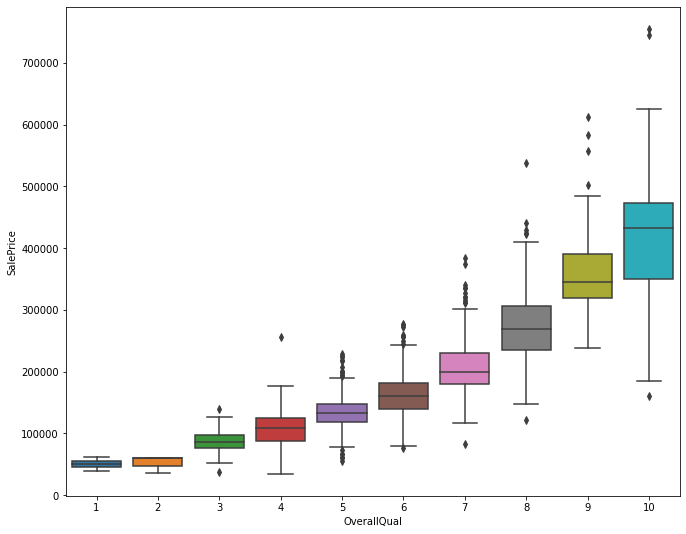

In [12]:
# Having a closer look on the most correlated feature (OverallQual)
fig, ax = plt.subplots(figsize=(11, 9))
sns.boxplot(x="OverallQual", y="SalePrice", data=train)
plt.show()

# The positive correlation is obvious with a slightly upward curve.
# Which indicates that as the overall quality of the house increases the price increases
# Except for 2 candidate outliers (in my opinion), there are no extreme cases.
# 1st candidate: expensive house in level 4
# 2nd candidate: expensive house in level 8

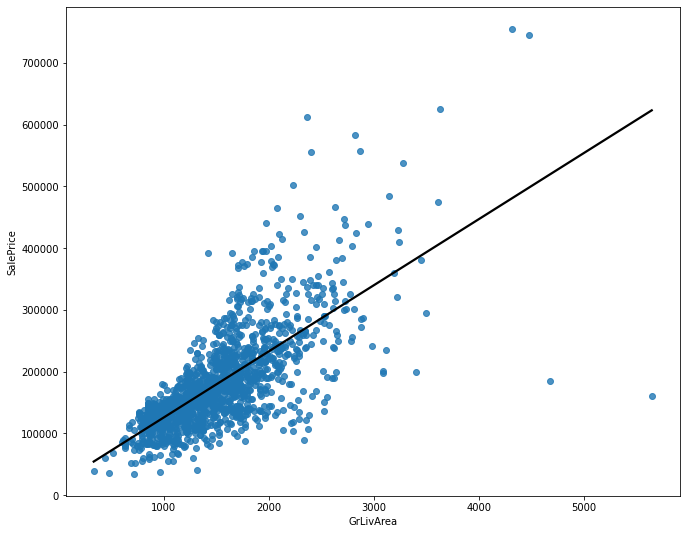

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [13]:
# Having a closer look on the second most correlated feature (GrLivArea)
fig, ax = plt.subplots(figsize=(11, 9))
# sns.scatterplot(x="GrLivArea", y="SalePrice", data=train)
sns.regplot(x="GrLivArea", y="SalePrice", data=train, ci=None, line_kws={"color":"black"})
plt.show()

# The positive linear relation is quite obvious here as well
# Which indicates that as the (above ground) living area increases the price increases as well
# There are 2 outliers (Id:1289 & 523) with huge living areas but very low prices (<200,000)
X_train['GrLivArea'].sort_values(ascending=False).head(2)

In [14]:
# Check completeness of data
col_has_null = all_data.isna().sum()
col_w_null = col_has_null[col_has_null > 0].index.to_list()
col_has_null[col_has_null > 0].sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

In [15]:
# Primary strategies for filling missing data (will see as we go if we need other strategies)
# For numerical features: assign 0
# For categorical features: assign None

# I make a copy so that I can compare before and after
all_data_original = all_data.copy()

# I will make a list of ordinal and categorical features that will need encoding
ordinal_features = []
nominal_features = []

In [16]:
# From the description of features, we find that there are multiple columns that use the same quality measures
# So we will encode them to an ordinal variable, so we can apply it to the different columns
quality_ordinal_encoder = OrdinalEncoder(categories=
                                         [['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                         ['Reg' 'IR1' 'IR2' 'IR3']])

In [17]:
# Pool Data : Quality and Area
# From the data description we know that Quality is categorical where NA means no pool
# So we can assign value None instead
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
print("PoolQC after filling missing values")
print(all_data[['PoolQC']].value_counts())

PoolQC after filling missing values
PoolQC
None      2909
Ex           4
Gd           4
Fa           2
dtype: int64


In [18]:
# Now let's check if there are pools that have no quality
all_data[(all_data['PoolQC'] == 'None') & (all_data['PoolArea'] > 0 )][['Id', 'PoolArea', 'PoolQC']]
# There are 3 houses !

,Id,PoolArea,PoolQC
960,2421,368,None
1043,2504,444,None
1139,2600,561,None


In [19]:
# A nice idea by ERIK BRUIN is to infer the quality of pool from the overall quality of the whole house
all_data[(all_data['PoolQC'] == 'None') & (all_data['PoolArea'] > 0 )][['Id', 'PoolArea', 'PoolQC', 'OverallQual']]

,Id,PoolArea,PoolQC,OverallQual
960,2421,368,None,4
1043,2504,444,None,6
1139,2600,561,None,3


In [20]:
# Assign the quality of pool to the mean of overall quality (overall quality scale is twice of the pool quality scale)
all_data.loc[all_data['Id'] == 2421, 'PoolQC'] = 'Fa'
all_data.loc[all_data['Id'] == 2504, 'PoolQC'] = 'TA'
all_data.loc[all_data['Id'] == 2600, 'PoolQC'] = 'Fa'

all_data[all_data['Id'].isin([2421,2504,2600])][['Id', 'PoolArea', 'PoolQC', 'OverallQual']]

# PoolQC will be ordinal encoded
ordinal_features.append('PoolQc')

In [21]:
# Misc Features
# From the data description we know that Misc is categorical where NA means no extra features
# So we can assign value None instead
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
print("MiscFeature after filling missing values")
all_data[['MiscFeature']].value_counts()

# MiscFeature will be one hot encoded
nominal_features.append('MiscFeature')

MiscFeature after filling missing values


In [22]:
# Alley
# From the data description we know that Alley is categorical where NA means no alley access
# So we cann assign value None instead
all_data['Alley'] = all_data['Alley'].fillna('None')
print('Alley after filling missing values')
all_data['Alley'].value_counts()

# Alley will be one hot encoded
nominal_features.append('Alley')

Alley after filling missing values


In [23]:
# Fence
# From the data description we know that Fence is categorical where NA means no Fence
# So we cann assign value None instead
all_data['Fence'] = all_data['Fence'].fillna('None')
print('Fence after filling missing values')
all_data['Fence'].value_counts()

# Fence will be one hot encoded
nominal_features.append('Fence')

Fence after filling missing values


In [24]:
# FirePlace Quality
# From the data description we know that FirePlace Quality is categorical where NA means no Fire Place
# So we cann assign value None instead
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')
print('FireplaceQu after filling missing values')
all_data['FireplaceQu'].value_counts()

FireplaceQu after filling missing values


None    1420
Gd       744
TA       592
Fa        74
Po        46
Ex        43
Name: FireplaceQu, dtype: int64

In [25]:
# Now let's check if there are Fireplaces that have no quality
all_data[(all_data['FireplaceQu'] == 'None') & (all_data['Fireplaces'] > 0)][['Id', 'Fireplaces', 'FireplaceQu']]
# There are none ! Everything looks good

# FireplaceQu will be ordinal encoded
ordinal_features.append('FireplaceQu')

In [26]:
# LotFrontage
# We know from the description that LotFrontage is numerical where NA is a missing value
# Another nice idea by ERIK BRUIN is to infer the LotFrontage from the values of the neighborhood
# But first let's check that all the neighborhoods have at least one value
print (all_data['Neighborhood'].nunique() == all_data[all_data['LotFrontage'].notna()]['Neighborhood'].nunique())

True


In [27]:
# Yes looks great! Now, let's assign the median value of LotFrontage from the same neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [28]:
# Let's also have a look on other Lot features (LotShape, LotConfig)

# LotShape
# from the descriptions it looks like an ordinal feature
print(all_data['LotShape'].unique()) #  Add values to ordinal encoder
ordinal_features.append('LotShape')

#LotConfig
print(all_data['LotConfig'].unique())
# Doesn't seem like an ordinal feature, so will consider as nominal
nominal_features.append('LotConfig')

['Reg' 'IR1' 'IR2' 'IR3']
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In [29]:
# Garage
# There are multple Garage variables with missing values
# GarageCond       159
# GarageYrBlt      159
# GarageFinish     159
# GarageQual       159
# GarageType       157
# In addition to 2 variables with 1 missing data
# GarageCars       1
# GarageArea       1

# First let's check if the nulls happen for the same records
all_data[(all_data['GarageCond'].isna()) & (all_data['GarageYrBlt'].isna()) & (all_data['GarageFinish'].isna()) & (all_data['GarageQual'].isna()) & (all_data['GarageType'].isna())].shape
# So 157 out of 159 are common

(157, 81)

In [30]:
# Now let's see the 2 cases where the difference happens
all_data[(all_data['GarageType'].notnull()) & (all_data['GarageCond'].isna())][['Id','GarageCond','GarageYrBlt','GarageFinish','GarageQual','GarageType','GarageCars','GarageArea', 'YearBuilt']]

# House 2127 looks like it has a garage (figure out how to fill the values)
# House 2577 looks like it doesn't have a garage (adjust values to reflect no garage)

,Id,GarageCond,GarageYrBlt,GarageFinish,GarageQual,GarageType,GarageCars,GarageArea,YearBuilt
666,2127,NaN,NaN,NaN,NaN,Detchd,1.0,360.0,1910
1116,2577,NaN,NaN,NaN,NaN,Detchd,NaN,NaN,1923


In [31]:
# For house 2127, I will consider the GarageYrBlt equal to YearBuilt (1910)
# I will check the most common properties of Garages for houses built at that year
all_data[all_data['YearBuilt'] == 1910].groupby(['GarageCond','GarageYrBlt','GarageFinish','GarageQual']).size().sort_values(ascending=False)

'GarageCond',
'GarageYrBlt',
'GarageFinish',
'GarageQual',
'GarageType',
'GarageCars'
'GarageArea'

'GarageArea'

In [32]:
# GarageCond
# from the descriptions it is an ordinal feature